# Import libraries

In [ ]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import optuna
import shap
from joblib import Parallel, delayed

import scikeras
from scikeras.wrappers import KerasRegressor

# Data Fetching

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def fetch_option_data(ticker, option_chain_date):
    """Fetches option data for a given ticker and expiration date."""
    try:
        stock = yf.Ticker(ticker)
        options = stock.option_chain(option_chain_date)
        calls = options.calls

        # Add historical stock price data
        historical_data = stock.history(period="1y")
        calls['underlying_price'] = historical_data['Close'].iloc[-1]
        calls['time_to_maturity'] = (pd.to_datetime(option_chain_date) - pd.Timestamp.today()).days / 365.0
        calls['implied_volatility'] = calls['impliedVolatility']
        calls['risk_free_rate'] = 0.01  # Assume a constant risk-free rate

        logger.info(f"Fetched option data for {ticker} on {option_chain_date}")
        return calls
    except Exception as e:
        logger.error(f"Error fetching data for {ticker}: {str(e)}")
        return None



# Data Preprocessing

In [ ]:
def preprocess_data(data):
    """Preprocesses the data by selecting features, splitting, and scaling."""
    try:
        features = ['underlying_price', 'strike', 'time_to_maturity', 'implied_volatility', 'risk_free_rate']
        X = data[features]
        y = data['lastPrice']

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        logger.info("Data preprocessing completed successfully.")
        return X_train_scaled, X_test_scaled, y_train, y_test
    except Exception as e:
        logger.error(f"Error in preprocessing data: {str(e)}")
        return None, None, None, None

def feature_engineering(X):
    """Performs feature engineering such as polynomial features."""
    try:
        poly = PolynomialFeatures(degree=2, interaction_only=True)
        X_poly = poly.fit_transform(X)
        logger.info("Feature engineering completed successfully.")
        return X_poly
    except Exception as e:
        logger.error(f"Error during feature engineering: {str(e)}")
        return None

# Model Training

In [ ]:
def train_linear_regression(X_train, y_train):
    """Trains a linear regression model."""
    try:
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        logger.info("Linear regression model trained successfully.")
        return lr_model
    except Exception as e:
        logger.error(f"Error training linear regression model: {str(e)}")
        return None


In [ ]:

def train_svr(X_train, y_train):
    """Trains a Support Vector Regressor model with hyperparameter tuning."""
    try:
        param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
        svr_model = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
        svr_model.fit(X_train, y_train)
        logger.info(f"Best Parameters for SVR: {svr_model.best_params_}")
        return svr_model.best_estimator_
    except Exception as e:
        logger.error(f"Error training SVR model: {str(e)}")
        return None




In [ ]:
def train_neural_network(X_train, y_train):
    """Trains a simple neural network with early stopping."""
    try:
        nn_model = Sequential([
            Dense(128, input_dim=X_train.shape[1], activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        nn_model.compile(optimizer='adam', loss='mse')

        # Early stopping
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping])

        logger.info("Neural network training completed with early stopping.")
        return nn_model
    except Exception as e:
        logger.error(f"Error training neural network: {str(e)}")
        return None


In [ ]:
def train_random_forest(X_train, y_train):
    """Trains a Random Forest model."""
    try:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        logger.info("Random Forest training completed.")
        return rf_model
    except Exception as e:
        logger.error(f"Error training Random Forest model: {str(e)}")
        return None

In [ ]:
def grid_search_svr(X_train, y_train):
    """Performs Grid Search to find the best hyperparameters for SVR."""
    param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
    svr_model = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
    svr_model.fit(X_train, y_train)
    logger.info(f"Best Parameters for SVR: {svr_model.best_params_}")
    return svr_model.best_estimator_


In [ ]:

def k_fold_cross_validation(model, X_train, y_train):
    """Performs K-Fold Cross-Validation."""
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    logger.info(f"K-Fold Cross-Validation Scores: {scores}")
    return scores



# Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, model_type='linear', lstm=False):
    """Evaluates the model and returns key metrics."""
    try:
        if lstm:
            X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        y_pred = model.predict(X_test)

        if model_type == 'keras':
            y_pred = y_pred.flatten()  # For neural networks and LSTM models

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        logger.info(f"Model evaluation completed: RMSE={rmse}, MAE={mae}, R^2={r2}")
        return {'metrics': {'RMSE': rmse, 'MAE': mae, 'R^2': r2}, 'y_pred': y_pred}
    # ... (rest of your function)
    except Exception as e:
        logger.error(f"Error during model evaluation: {str(e)}")
        return {'metrics': None, 'y_pred': None}

# Model Comparison and Visualization

In [ ]:
def compare_models(results):
    """Compares the models based on RMSE and MAE and visualizes the results."""
    # Extract metrics to top-level columns
    flattened_results = []
    for result in results:
        flattened_result = {'Model': result['Model']}
        flattened_result.update(result['metrics'])  # Extract metrics
        flattened_results.append(flattened_result)

    df = pd.DataFrame(flattened_results)  # Create DataFrame from flattened results

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='RMSE', data=df)
    plt.title('Model Comparison - RMSE')

    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='MAE', data=df)
    plt.title('Model Comparison - MAE')

    plt.show()

    logger.info("Model comparison completed.")
    print(df)

# Cross Validation

In [ ]:
def k_fold_cross_validation(model, X_train, y_train):
    """Performs K-Fold Cross-Validation."""
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    logger.info(f"K-Fold Cross-Validation Scores: {scores}")
    return scores


# Main

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


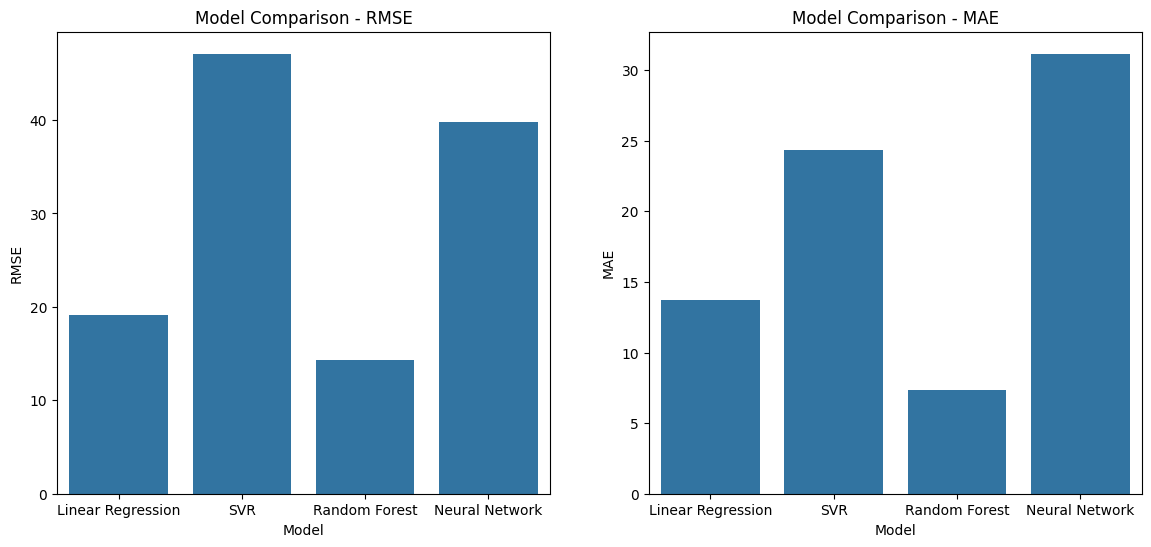

               Model       RMSE        MAE       R^2
0  Linear Regression  19.092803  13.696278  0.933994
1                SVR  47.090193  24.330413  0.598479
2      Random Forest  14.337798   7.349033  0.962777
3     Neural Network  39.750201  31.160136  0.713895


In [ ]:
def main():
    # Fetch and preprocess data
    ticker = 'AAPL'
    option_chain_date = '2024-12-20'
    data = fetch_option_data(ticker, option_chain_date)
    if data is None:
        logger.error("Failed to fetch or preprocess data. Exiting.")
        return

    X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(data)
    if X_train_scaled is None or y_train is None:
        logger.error("Failed to preprocess data. Exiting.")
        return

    # Feature engineering
    X_train_scaled = feature_engineering(X_train_scaled)
    X_test_scaled = feature_engineering(X_test_scaled)

    # Train models
    lr_model = train_linear_regression(X_train_scaled, y_train)
    svr_model = train_svr(X_train_scaled, y_train)
    rf_model = train_random_forest(X_train_scaled, y_train)
    nn_model = train_neural_network(X_train_scaled, y_train)

    # Cross-validation
    k_fold_cross_validation(lr_model, X_train_scaled, y_train)

    # Evaluate models
    results = []

    metrics = evaluate_model(lr_model, X_test_scaled, y_test)
    results.append({'Model': 'Linear Regression', **metrics})

    metrics = evaluate_model(svr_model, X_test_scaled, y_test)
    results.append({'Model': 'SVR', **metrics})

    metrics = evaluate_model(rf_model, X_test_scaled, y_test)
    results.append({'Model': 'Random Forest', **metrics})

    metrics = evaluate_model(nn_model, X_test_scaled, y_test, model_type='keras')
    results.append({'Model': 'Neural Network', **metrics})

    # Compare and visualize results
    compare_models(results)

if __name__ == "__main__":
    main()
